In [82]:
import numpy as np
from numpy.fft import fft2, ifft2, fftshift
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import cm
import scipy

#Import some image analysis functions
from scipy.ndimage import gaussian_filter1d as gf1d
from scipy.ndimage import gaussian_filter as gf
from scipy.ndimage import uniform_filter as uf

import sys

##################################################################################################
# CHANGE THIS TO THE PATH WHERE THE DDM CODE IS (GET FROM GITHUB IF YOU HAVEN'T YET)             #
path_to_ddm_code = "C:\\Users\\rmcgorty\\Documents\\GitHub\\Differential-Dynamic-Microscopy---Python\\"
##################################################################################################

sys.path.append(path_to_ddm_code)
import radiav
import tiff_file
import ddm_clean as ddm
import gaussfitter

In [2]:
%matplotlib notebook

Imports not working? Make sure to grab the [DDM repository from GitHub](https://github.com/rmcgorty/Differential-Dynamic-Microscopy---Python). 

Don't know what all those scipy.ndimage functions are? [Check out the documentation](https://docs.scipy.org/doc/scipy/reference/ndimage.html). 

In [3]:
def im_corr(image, filter=False, filtersize=80):
    '''
    This function computes the image correlation. 
    Inputs:
        image - the 2D matrix of the image
        filter (optional) - boolean, defaults to False. Whether or not to filter image using the uniform filter
        filtersize (optional) - defaults to 80. Size of filter
    Outputs:
        corr_im - the correlation (same size as input image)
        rav_corr - radially averaged correlation
    '''
    
    #If the 'filter' optional argument is true, then filter the image
    if filter:
        image = filtimage(image, filtersize = filtersize)
        
    #Subtract of the mean and divide by standard deviation (so that the maximum
    #  of the correlation function will be 1)
    image = 1.0*image-image.mean()
    image = image/image.std()
    
    #Use Fourier transforms to calculate the correlation
    corr_im = fftshift(ifft2(fft2(image)*np.conj(fft2(image))))/(image.shape[0]*image.shape[1])
    
    corr_im = corr_im.astype(np.float32)
    
    #Compute radial average
    rav_corr = ddm.newRadav(corr_im)
    
    
    return corr_im, rav_corr

def filtimage(image, filtersize=80):
    '''
    Filters image using the scipy.ndimage function uniform_filter
    '''
    image = image*1.0 - uf(image,filtersize)
    return image

In [189]:
movie_num = 5
#data_trial = 10
shear_rate = 0.5

#Set directory where to find the data:
main_data_dir = "Y:\\Dennis Terwilliger\\Data\\2021-01-15\\01_Temp ramp_0.5Hz_(23-35Deg)_(35-23Deg)Mac_1.02pm\\"
data_dir = "01_Temp ramp_%.1fHz_(23-35Deg)_(35-23Deg)Mac_1.02pm_%i\\" % (shear_rate, movie_num)

data_file = "01_Temp ramp_%.1fHz_(23-35Deg)_(35-23Deg)Mac_1.02pm_%i.tif" % (shear_rate, movie_num)

full_filenm = main_data_dir+data_dir+data_file

In [190]:
im_stack = tiff_file.imread(full_filenm)

C:\Users\rmcgorty\Documents\GitHub\Differential-Dynamic-Microscopy---Python\tiff_file.py:724: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  result = numpy.vstack((p.asarray() if p else nopage)


In [191]:
print("Shape of im_stack: ", im_stack.shape)

Shape of im_stack:  (2000, 560, 596)


<IPython.core.display.Javascript object>


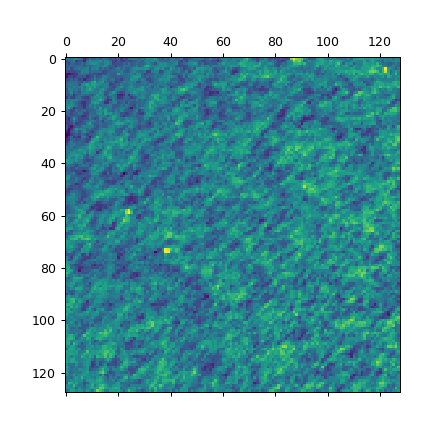

In [192]:
im_size = 128
xstart = 200
ystart = 220
plt.matshow(im_stack[10, xstart:xstart+im_size, ystart:ystart+im_size])

In [193]:
median_im = np.median(im_stack[:,xstart:xstart+im_size, ystart:ystart+im_size],axis=0)

<IPython.core.display.Javascript object>


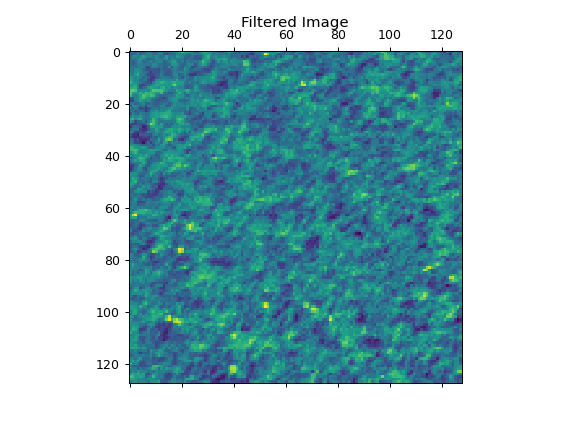

Text(0.5, 1.05, 'Filtered Image')

In [194]:
frame_num = 1500
im = im_stack[frame_num, xstart:xstart+im_size, ystart:ystart+im_size]
im_filt = filtimage(im*1.0 - median_im, filtersize=100)
plt.figure()
plt.matshow(im_filt, fignum=0)
plt.title("Filtered Image")

In [195]:
corr_im, corr_rad = im_corr(im - median_im,filter=True,filtersize=100)

<ipython-input-3-d2d48a41325d>:25: ComplexWarning: Casting complex values to real discards the imaginary part
  corr_im = corr_im.astype(np.float32)


<IPython.core.display.Javascript object>


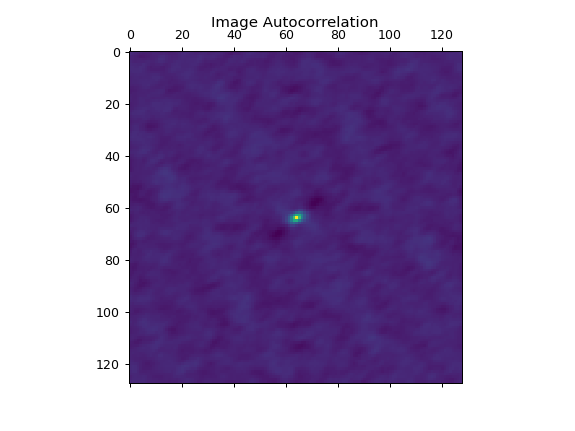

Text(0.5, 1.05, 'Image Autocorrelation')

In [196]:
plt.figure()
plt.matshow(corr_im, fignum=0)
plt.title("Image Autocorrelation")

<IPython.core.display.Javascript object>


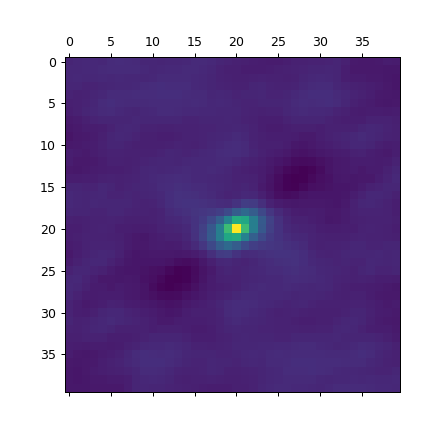

min:  -0.10932888
max:  1.0


In [197]:
xc = 64
sz = 20
corr_im_section = corr_im[xc-sz:xc+sz, xc-sz:xc+sz]
plt.matshow(corr_im_section)
print("min: ", corr_im_section.min())
print("max: ", corr_im_section.max())

In [228]:
ret = gaussfitter.gaussfit(corr_im_section, params = [0,1.0,20,20,5,2,45], returnfitimage=True, quiet=False)

Iter       1    CHI-SQUARE =  13.69591858  DOF =  1593
   HEIGHT = 0  
   AMPLITUDE = 1  
   XSHIFT = 20  
   YSHIFT = 20  
   XWIDTH = 5  
   YWIDTH = 2  
   ROTATION = 45  
Iter       2    CHI-SQUARE =  1.70979009  DOF =  1593
   HEIGHT = 0.001490163088  
   AMPLITUDE = 0.5547321912  
   XSHIFT = 20.00000014  
   YSHIFT = 19.99999994  
   XWIDTH = 3.509243308  
   YWIDTH = 2.010720821  
   ROTATION = 47.98263816  
Iter       3    CHI-SQUARE =  1.306730283  DOF =  1593
   HEIGHT = -0.0007014084725  
   AMPLITUDE = 0.6304919356  
   XSHIFT = 19.99999994  
   YSHIFT = 19.99999999  
   XWIDTH = 2.457031007  
   YWIDTH = 1.960556965  
   ROTATION = 61.06906335  
Iter       4    CHI-SQUARE =  1.203164984  DOF =  1593
   HEIGHT = -0.0008777393674  
   AMPLITUDE = 0.679564118  
   XSHIFT = 20  
   YSHIFT = 20.00000007  
   XWIDTH = 2.664012806  
   YWIDTH = 1.762383545  
   ROTATION = 77.93078951  
Iter       5    CHI-SQUARE =  1.18092629  DOF =  1593
   HEIGHT = -0.0009653446476  
   AMPLIT

In [229]:
print(ret[0].shape)

(7,)


<IPython.core.display.Javascript object>


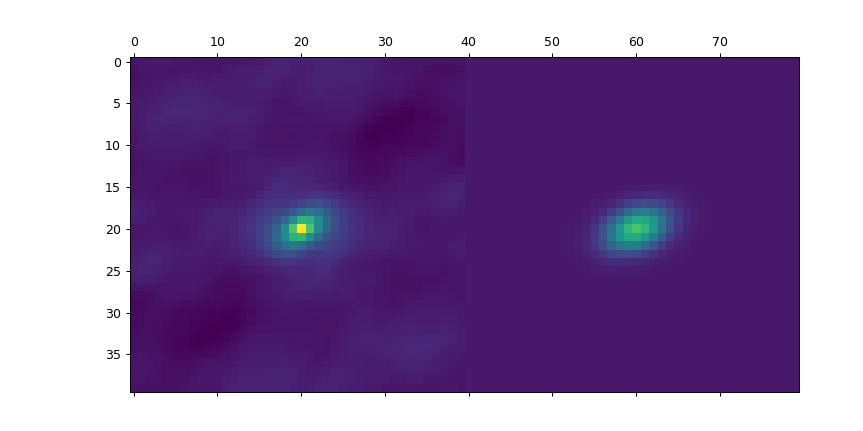

In [230]:
plt.matshow(np.hstack((corr_im_section,ret[1])))

In [201]:
new_ims = im_stack[:, xstart:xstart+im_size, ystart:ystart+im_size]*1.0 - median_im

In [202]:
x = np.arange(-1*corr_im.shape[1]/2, corr_im.shape[1]/2, 1)
y = np.arange(-1*corr_im.shape[0]/2, corr_im.shape[0]/2, 1)
xx, yy = np.meshgrid(x, y)
#print("Shape of image corr: ", corr_images[0].shape)
#print("Shape of xx: ", xx.shape)
cos2theta = np.cos(2*np.arctan(1.0*xx/yy))

xc = int(corr_im.shape[0]/2)
yc = int(corr_im.shape[1]/2)
print(xc)

64


<ipython-input-202-106b8b349147>:6: RuntimeWarning: divide by zero encountered in true_divide
  cos2theta = np.cos(2*np.arctan(1.0*xx/yy))
<ipython-input-202-106b8b349147>:6: RuntimeWarning: invalid value encountered in true_divide
  cos2theta = np.cos(2*np.arctan(1.0*xx/yy))


In [203]:
corr_im.shape

(128, 128)

In [237]:
#frames_to_analyze = np.array([70,170,270,370,470,570,670,770,870,970,1070,1170,1270,1370,1470,1570,1670,1770,1870])
frames_to_analyze = np.arange(0,2000,10)
num_frames_to_avg = 5
filtersize=100
every = 2
corr_images = np.zeros((len(frames_to_analyze),im_size,im_size),dtype=np.float64)
temp = np.zeros((im_size,im_size),dtype=np.float64)
af = np.zeros((len(frames_to_analyze),200),dtype=np.float64)
gaussfit_params = np.zeros((len(frames_to_analyze), 7))

for i,frames in enumerate(frames_to_analyze):
    for j in range(num_frames_to_avg):
        temp, corr_rad = im_corr(new_ims[frames+(j*every)],filter=True,filtersize=filtersize)
        corr_images[i] = corr_images[i] + temp
    corr_images[i] = corr_images[i] / num_frames_to_avg
    
    alignment_factor_numerator, _ = radiav.radav(corr_images[i] * cos2theta, xc, yc, 200)
    alignment_factor_denominator, _ = radiav.radav(corr_images[i], xc, yc, 200)

    af[i] = alignment_factor_numerator / alignment_factor_denominator
    
    xc = 64
    sz = 20
    corr_im_section = corr_images[i][xc-sz:xc+sz, xc-sz:xc+sz]
    minpars = [0,0,0,0,1,1,0]
    ret = gaussfitter.gaussfit(corr_im_section, params = [0,1.0,20,20,5,2,45], minpars=minpars, returnfitimage=False, quiet=True)
    gaussfit_params[i] = ret

<ipython-input-3-d2d48a41325d>:25: ComplexWarning: Casting complex values to real discards the imaginary part
  corr_im = corr_im.astype(np.float32)
C:\Users\rmcgorty\Documents\GitHub\Differential-Dynamic-Microscopy---Python\radiav.py:21: RuntimeWarning: invalid value encountered in true_divide
  return radsum/numsum, numsum


In [238]:
xyratio = gaussfit_params[:,5]/gaussfit_params[:,4]

<IPython.core.display.Javascript object>


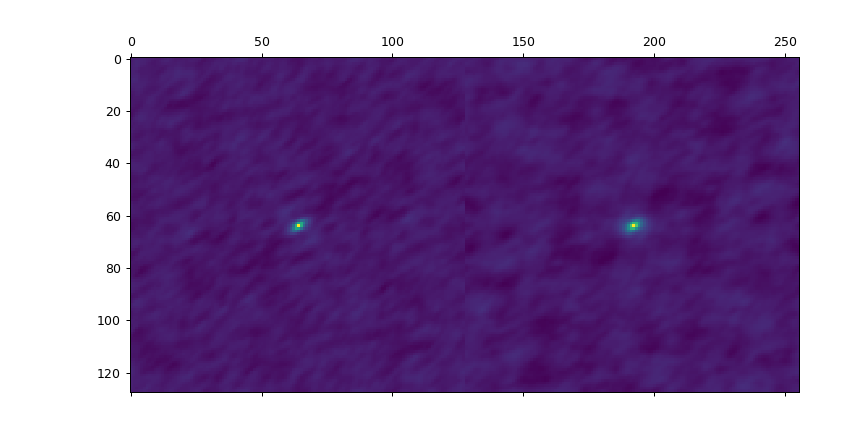

In [239]:
plt.matshow(np.hstack((corr_images[0],corr_images[-1])))

<IPython.core.display.Javascript object>


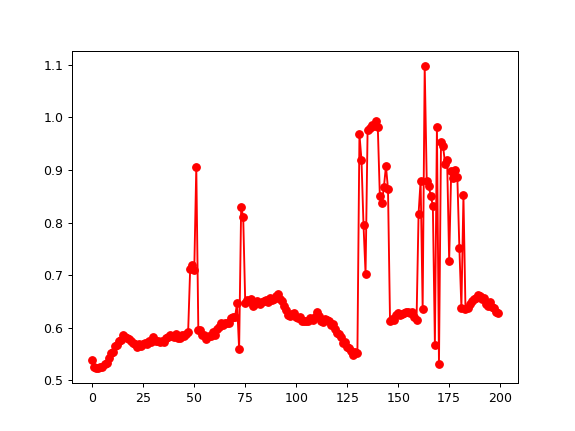

In [240]:
plt.figure()
plt.plot(xyratio,'-ro')

In [241]:
xyratio5 = xyratio.copy()

<IPython.core.display.Javascript object>


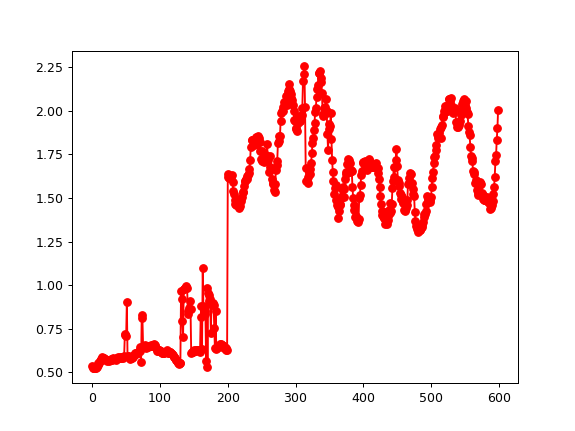

In [242]:
plt.figure()
plt.plot(np.hstack((xyratio5,xyratio6, xyratio7)),'-ro')

<IPython.core.display.Javascript object>


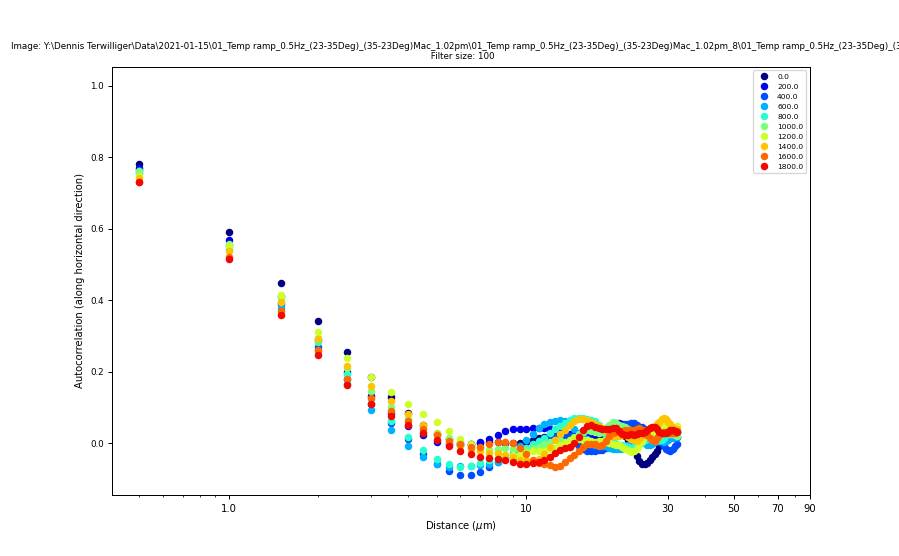

[Text(0, 0, '1.0'),
 Text(0, 0, '10'),
 Text(0, 0, '30'),
 Text(0, 0, '50'),
 Text(0, 0, '70'),
 Text(0, 0, '90')]

In [79]:
#Here, we plot a *horizontal* slice through the image autocorrelation.

cmap = matplotlib.cm.get_cmap('jet')

nx,ny = corr_images[0].shape
x_mid = int(nx/2); y_mid = int(ny/2)


figsize = 10.0
fig, ax = plt.subplots(figsize=(figsize,figsize/1.618))
xvalues = np.arange(y_mid+1)*0.501 #For the rheometer microscope with 20x objective pixel size is 0.501um
ax.tick_params(axis='both', which='major', labelsize=7)
markerSize = 5
mark = 'o'
j=0
for i,frames in enumerate(frames_to_analyze):
    plt.semilogx(xvalues, np.flip(corr_images[i,x_mid, 0:y_mid+1]),mark,ms=markerSize,
                 c=cmap(i/(1.0*len(frames_to_analyze))),label="%.1f" % frames)

plt.xlabel("Distance ($\mu$m)",fontsize=8)
plt.ylabel("Autocorrelation (along horizontal direction)",fontsize=8)
plt.title("Image: %s. \n Filter size: %i" % (main_data_dir+data_dir+data_file[:-23], filtersize), fontsize=7)
plt.legend(loc=0,fontsize=6)


ax.set_xticks([1.0, 10, 30, 50, 70, 90])
ax.set_xticklabels(['1.0','10','30','50','70','90'], fontsize=8)
#plt.savefig(main_data_dir+data_dir+data_file[:-23]+"_xcorr.png")

<IPython.core.display.Javascript object>


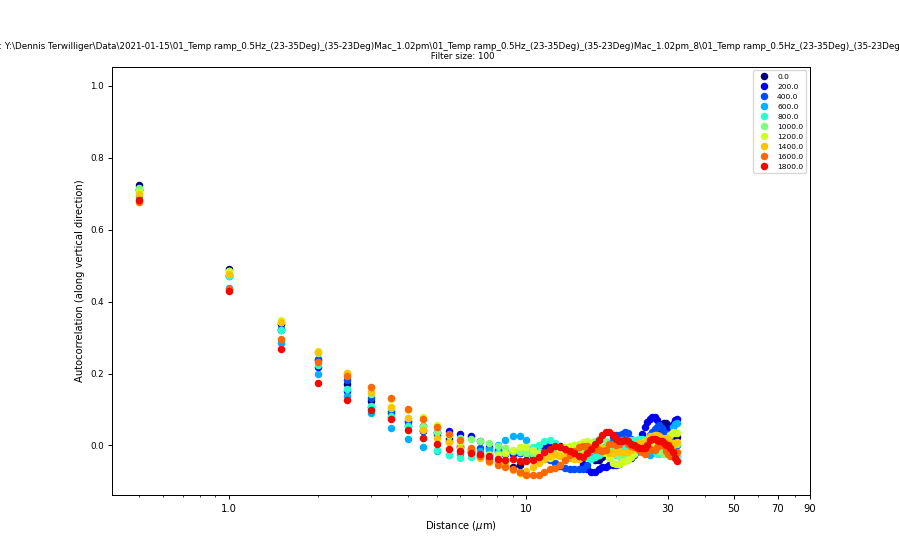

[Text(0, 0, '1.0'),
 Text(0, 0, '10'),
 Text(0, 0, '30'),
 Text(0, 0, '50'),
 Text(0, 0, '70'),
 Text(0, 0, '90')]

In [80]:
#Here, we plot a *vert* slice through the image autocorrelation.

cmap = matplotlib.cm.get_cmap('jet')

nx,ny = corr_images[0].shape
x_mid = int(nx/2); y_mid = int(ny/2)


figsize = 10.0
fig, ax = plt.subplots(figsize=(figsize,figsize/1.618))
xvalues = np.arange(x_mid+1)*0.501 #For the rheometer microscope with 20x objective pixel size is 0.501um
ax.tick_params(axis='both', which='major', labelsize=7)
markerSize = 5
mark = 'o'
j=0
for i,frames in enumerate(frames_to_analyze):
    plt.semilogx(xvalues, np.flip(corr_images[i,0:x_mid+1, y_mid]),mark,ms=markerSize,
                 c=cmap(i/(1.0*len(frames_to_analyze))),label="%.1f" % frames)

plt.xlabel("Distance ($\mu$m)",fontsize=8)
plt.ylabel("Autocorrelation (along vertical direction)",fontsize=8)
plt.title("Image: %s. \n Filter size: %i" % (main_data_dir+data_dir+data_file[:-8], filtersize), fontsize=7)
plt.legend(loc=0,fontsize=6)


ax.set_xticks([1.0, 10, 30, 50, 70, 90])
ax.set_xticklabels(['1.0','10','30','50','70','90'], fontsize=8)
#plt.savefig(main_data_dir+data_dir+data_file[:-23]+"_ycorr.png")

<IPython.core.display.Javascript object>


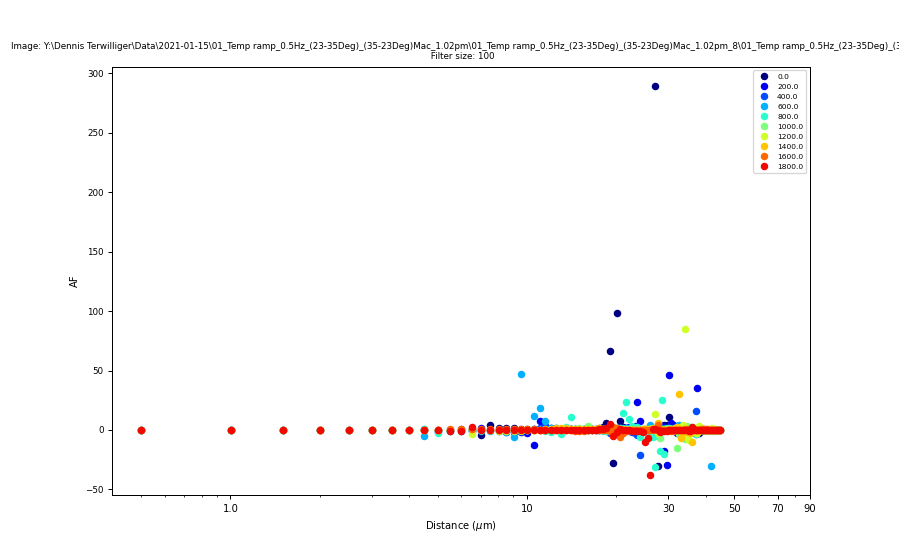

'\nAlignment factor from: Varga, Z. & Swan, J. W. Large scale anisotropies in sheared colloidal gels. \nJournal of Rheology 62, 405–418 (2018).\n\n'

In [121]:
#Here, we plot a *horizontal* slice through the image autocorrelation.

cmap = matplotlib.cm.get_cmap('jet')

nx,ny = corr_images[0].shape
x_mid = int(nx/2); y_mid = int(ny/2)


figsize = 10.0
fig, ax = plt.subplots(figsize=(figsize,figsize/1.618))
xvalues = np.arange(200)*0.501 #For the rheometer microscope with 20x objective pixel size is 0.501um
ax.tick_params(axis='both', which='major', labelsize=7)
markerSize = 5
mark = 'o'
j=0
for i,frames in enumerate(frames_to_analyze):
    plt.semilogx(xvalues, af[i],mark,ms=markerSize,
                 c=cmap(i/(1.0*len(frames_to_analyze))),label="%.1f" % frames)

plt.xlabel("Distance ($\mu$m)",fontsize=8)
plt.ylabel("AF",fontsize=8)
plt.title("Image: %s. \n Filter size: %i" % (main_data_dir+data_dir+data_file[:-23], filtersize), fontsize=7)
plt.legend(loc=0,fontsize=6)


ax.set_xticks([1.0, 10, 30, 50, 70, 90])
ax.set_xticklabels(['1.0','10','30','50','70','90'], fontsize=8)
#plt.savefig(main_data_dir+data_dir+data_file[:-23]+"_AF.png")

'''
Alignment factor from: Varga, Z. & Swan, J. W. Large scale anisotropies in sheared colloidal gels. 
Journal of Rheology 62, 405–418 (2018).

'''

In [122]:
#Here, we sum the AF up to distance of 20 um (index of 40)

af_upto20 = np.zeros((af.shape[0]))
for i in range(af.shape[0]):
    af_upto20[i] = af[i,1:40].sum()

<IPython.core.display.Javascript object>


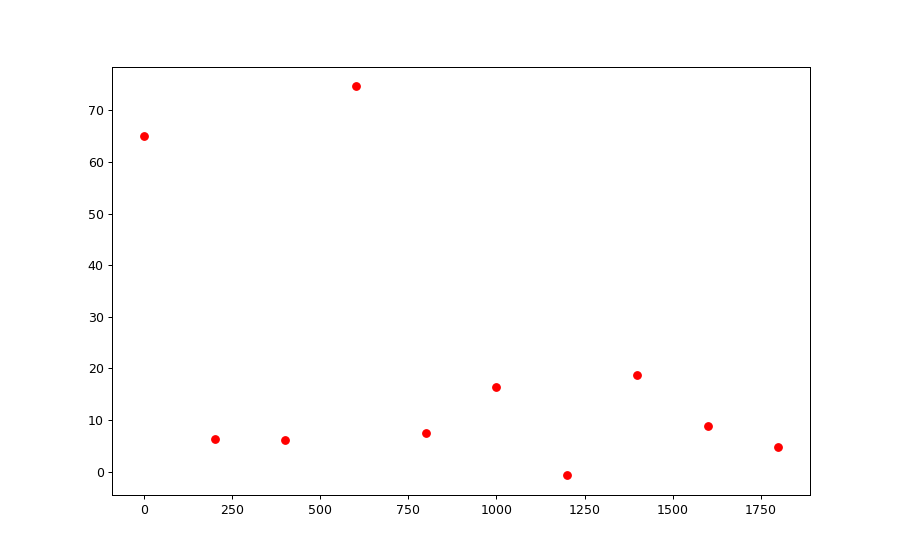

In [123]:
figsize = 10.0
fig, ax = plt.subplots(figsize=(figsize,figsize/1.618))
plt.plot(frames_to_analyze, af_upto20,'ro')

In [ ]:
dict_to_pickle = {}
dict_to_pickle['data_dir'] = main_data_dir+data_dir+data_file[:-23]
dict_to_pickle['filtersize'] = filtersize
dict_to_pickle['frames_analyzed'] = frames_to_analyze
dict_to_pickle['num_frames_to_avg'] = num_frames_to_avg
dict_to_pickle['every'] = every
dict_to_pickle['corr_images'] = corr_images
dict_to_pickle['af'] = af
dict_to_pickle['af_upto20'] = af_upto20

In [ ]:
import pickle

data_dump_file = open(main_data_dir+data_dir+data_file[:-23]+"_pickleddata.p",'wb')
pickle.dump(dict_to_pickle, data_dump_file)
data_dump_file.close()